---

## HW01 AutoEncoder (PyTorch)

다음을 확인하는 리포트를 Colab 노트북을 이용해 작성한다.

1. 정규분포를 통한 파라미터 초기화를 진행한 `Linear` layer를 Xavier 초기화, He 초기화 기법을 통해 초기화를 진행한 뒤, 결과에 대해 분석한다.

2. Autoencoder의 encoder를 거쳐 나온 representation $z$를 groud truth(GT) label별로 다른색을 주어 $z$의 분포를 가시화한다.

3. $z$의 분포를 보고 encoder가 label별로 discriminative한 representation을 만들어내는지 확인한다.

4. 만일 discriminative하지 않다면, autoencoder가 discriminative한 representation $z$를 학습하도록 $z$의 차원을 바꿔가면서 실험해본다.

5. $z$ 공간의 임의의 위치를 sampling한 후, 학습된 decoder의 입력으로 주는 방식으로 generative model을 구축한다. <br/>
의미있게 만들어진 이미지는 어떤 특징을 갖고 있는지 논의한다.

6. Autoencoder의 `LInear` layer를 `Conv` layer로 수정하여 실험을 진행한다.

---

# 오토인코더 (Pytorch)
Pytorch에서 제공하는 고수준 API를 이용해, 오토인코더(autoencoder)를 구현한다.

참고문헌
* [Pytorch tutorial](https://tutorials.pytorch.kr/)
* [Dive into Deep learning](https://d2l.ai/)


주의사항
* Colab에서 코드에 이상이 없음에도 불구하고 결과가 제대로 나오지 않을 경우, '런타임 다시 시작...'을 해보도록 한다.'


## Deep Neural Network 기초
다음 비디오를 보고 심층신경망(deep neural network) 기반 딥러닝 기법은 이해하도록 한다.
* [신경망이란 무엇인가? | 1장.딥러닝에 관하여 (3Blue1Brown)](https://youtu.be/aircAruvnKk)
* [경사 하강, 신경 네트워크가 학습하는 방법 | 심층 학습, 2장 (3Blue1Brown)](https://youtu.be/IHZwWFHWa-w)
* [What is backpropagation really doing? | Deep learning, chapter 3 (3Blue1Brown)](https://youtu.be/Ilg3gGewQ5U)
* [Backpropagation calculus | Deep learning, chapter 4 (3Blue1Brown)](https://youtu.be/tIeHLnjs5U8)

## 필요한 모듈 임포트


In [ ]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

import torch                                      # 파이토치 임포트
import torch.nn as nn                             # nn 모듈 임포트
import torch.nn.functional as F

import torchvision                                # torchvision 임포트
import torchvision.utils as utils
import torchvision.transforms as transforms       # numpy 이미지에서 tensor 이미지로 변경하기 위한 모듈
import torchvision.datasets as datasets           # pytorch에 내장된 dataset을 불러오기 위한 모듈

from tqdm import tqdm

print("Python:", sys.version)
print("Numpy:", np.__version__)

print("Torch: ", torch.__version__)               # 파이토치 버전을 확인하도록 한다.
print("Torchvision: ", torchvision.__version__)   # 토치비전 버전을 확인하도록 한다.


Python: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
Numpy: 1.22.4
Torch:  1.13.1+cu116
Torchvision:  0.14.1+cu116


## GPU 동작 확인

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
  print(torch.cuda.get_device_name(0))

cuda:0
True
Tesla T4


## Hyperparameter 설정
* batch size, learning rate, epoch을 설정

In [ ]:
batch_size    = 100
learning_rate = 0.001
num_epochs    = 10 # 데이터셋 전체를 10번 보겠다

## MNIST 데이터셋 띄우기
![MnistExamples.png](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)
* mnist 데이터셋은 숫자(digit) 손글씨 데이터셋이다.
* 60,000개의 트레이닝 데이터와 10,000개의 테스트 데이터로 이루어져 있다.
* LeCun이 자신의 연구에서 활용하고 배포한 데이터셋이 있으나 최근 보편적으로 많이 활용하기 때문에 텐서플로우나 파이토치 등에서 built-in 데이터셋의 형태로 제공해 주기도 한다.  

### MNIST 이미지 데이터
* MNIST 데이터셋은 여러 버젼이 있으나, 여기서는 이를 파이토치에 맞게 정리하여 torchvision.datasets에서 built-in으로 제공하는 데이터셋을 쓰도록 하겠다. ([link](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html)) 
  + (PIL image, integer label)로 구성된 데이터를 제공.
  + PIL image는 각 픽셀이 [0, 255] 사이값으로 구성된 H x W x C 크기의 이미지이다.
* 뉴럴넷의 입력으로 넣기 위해 픽셀값이 0 근처에 있는 작은 실수값을 가지도록 다음과 같이 변환한다.
  + ToTensor(): [0, 255] 사이 값을 [0.0, 1.0] 사이값으로 변화시킴과 동시에 C x H x W 형태로 변환시킨다.


In [ ]:
# 픽셀 데이터 ( gray value ) <= number of channels = 1
# 딥러닝의 자료구조 = tensor
# 숫자 하나 존재 = zero tensor
# 숫자들 (3, 2) = vector
# - 숫자를 한방향으로 늘림 (3, 2, 1) = 1-tensor
# 행렬
# - 숫자를 두방향으로 늘림 (2, 3, 4) 
#                     (1, 3, 2) = 2-tensor
# [[1]] = 2-tensor
# [1] = 1-tensor
# 1 = 0-tensor

# mnist dataset은 tensor 구조가 height * width * channel 인 3-tensor
# => 시작하기 전에 공식문서 가서 무조건 확인해야함

# pytorch는 channel * height * width로 봄

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# download path 정의
download_root = './MNIST_DATASET'


# PIL image (H x W x C) -> torch tensor (C x H x W) and 
# [0, 255] -> [0.0, 1.0] = 확률인것처럼 변환
mnist_transform = transforms.Compose([
    transforms.ToTensor(), # 텐서 구조로 바꿈
])


train_dataset = MNIST(download_root, 
                      transform=mnist_transform, 
                      train=True, 
                      download=True)

test_dataset = MNIST(download_root,
                     transform=mnist_transform, 
                     train=False, 
                     download=False)

## 데이터셋 확인
데이터셋을 로딩한 후 **데이터셋 구성**이 어떻게 되어 있는지 **반드시 확인**하는 습관을 가지도록 한다.

torchvision.datasets.MNIST 데이터셋의 각 데이터는 (이미지, 레이블)로 구성된 튜플이다. 

다음은 MNIST 데이터셋에 있는 이미지와 레이블에 대한 각종 정보를 확인하는 코드이다. 

해당 코드를 통해 다음 사항을 확인할 수 있다.
* train_dataset의 길이는 60,000이다. 
* test_dataset의 길이는 10,000이다.

### MNIST 이미지 데이터
* 각 이미지는 C X H x W 순서로 구성된 [1, 28, 28] 모양의 텐서로 로딩되었다.
* 각 이미지 픽셀값은 ToTensor() 변환을 통해 [0.0, 1.0] 사이의 값으로 변환되었다.
* 각 이미지 픽셀값은 `torch.float32` 타입이다.
* 각 레이블 값의 타입은 파이썬 `int` 형이다.

### MNIST 라벨 데이터
* 각 레이블 값은 [0, 9] 사이의 파이썬 `int`형이다.

In [ ]:
# 파이썬에서 항상 dtype 체크해야함

def print_MNIST_dataset_info(dataset):
  print(">>> dataset length: ", len(dataset))
  print(">>> type of each data: ", type(dataset[0])) # tuple (image, target)
  first_img, first_label = dataset[0]
  print(">>> image shape: ", first_img.shape) # tensor dimension check
  print(">>> image dtype: ", first_img.dtype) # 각각의 자료구조 0~1사이 -> float32
  print(">>> image pixel min-value: ", first_img.min())
  print(">>> image pixel max-value: ", first_img.max())
  print(">>> label data type: ", type(first_label))

print("train dataset")
print_MNIST_dataset_info(train_dataset)

print("test dataset")
print_MNIST_dataset_info(test_dataset)

train dataset
>>> dataset length:  60000
>>> type of each data:  <class 'tuple'>
>>> image shape:  torch.Size([1, 28, 28])
>>> image dtype:  torch.float32
>>> image pixel min-value:  tensor(0.)
>>> image pixel max-value:  tensor(1.)
>>> label data type:  <class 'int'>
test dataset
>>> dataset length:  10000
>>> type of each data:  <class 'tuple'>
>>> image shape:  torch.Size([1, 28, 28])
>>> image dtype:  torch.float32
>>> image pixel min-value:  tensor(0.)
>>> image pixel max-value:  tensor(1.)
>>> label data type:  <class 'int'>


## MNIST DataLoader 정의

파이토치 데이터로더는 데이터셋을 배치단위로 묶어 순회(iteration)할 수 있도록 한다. 

아래 코드는 데이터셋에 대한 데이터로더를 만들고, 각 배치가 어떤 텐서 형태로 구성되어 있는지 확인하는 코드이다. 
* 데이터로더에서는 이미지들이 배치단위로 묶였기 때문에, [B, C, H, W] 모양의 텐서가 되었음을 확인하자.
* 데이터로더에서는 레이블들이 배치단위로 묶였기 때문에, [B] 모양의 텐서가 되었음을 확인하자.

train_dataset과 test_dataset은 동일 형태이므로, train_dataset의 데이터로더에 대해서만 확인하였다.



In [ ]:
from torch.utils.data import DataLoader

# dataloader 정의
# = batch 단위로 data를 feeding 해줌
# -> [B, C, H, W] = 4-tensor = 함수 입력의 꼴 / 모델에 batch단위로 넣음
# iterator를 설계
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

In [ ]:
def print_MNIST_data_loader_info(data_loader):
  print(">>> dataset length: ", len(data_loader))
  print(">>> batch_size: ", data_loader.batch_size)
  batch_images, batch_labels = next(iter(train_loader))
  # batch size로 묶은 data 이미지의 형태 확인
  print(">>> batch_images type", type(batch_images))
  print(">>> batch_images shape", batch_images.shape)
  print(">>> batch_images dtype", batch_images.dtype)

print("train dataset")
print_MNIST_data_loader_info(train_loader)

print("test dataset")
print_MNIST_data_loader_info(test_loader)

train dataset
>>> dataset length:  600
>>> batch_size:  100
>>> batch_images type <class 'torch.Tensor'>
>>> batch_images shape torch.Size([100, 1, 28, 28])
>>> batch_images dtype torch.float32
test dataset
>>> dataset length:  100
>>> batch_size:  100
>>> batch_images type <class 'torch.Tensor'>
>>> batch_images shape torch.Size([100, 1, 28, 28])
>>> batch_images dtype torch.float32


### 첫번째 배치의 첫번째 이미지와 레이블 확인
첫 이미지와 해당 레이블을 찍어서 확인해 보자.

C x H x W 이미지 정보가 보관된 파이토치 텐서를 H x W x C 형태의 PIL 이미지로 변환시키는 편리한 방법은 `to_pil_images` 함수를 사용하는 것이다. 이 예제에서는 [-1.0, 1.0] 값으로 픽셀값이 normalize되어 있으므로, [0.0, 1.0] 값으로 denormalize 시킨 후, 호출하면 [0, 255] 값으로 변환된다.


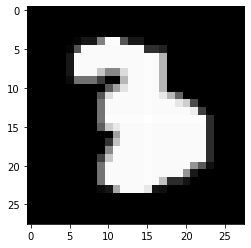

In [ ]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# 첫번째 이미지 한장에 대한 확인
# 100개 이미지, 100개 레이블
# batch[0-99]
batch_images, batch_labels = next(iter(train_loader))

img = batch_images[0]

plt.figure()
plt.imshow(to_pil_image(img), cmap='gray')

## 네트워크 모델 설계
* 인코더 모델: `torch.nn.Sequential` 모듈로 모델로 설계
  + InputLayer로 (28,28) 영상을 받고, Linear 레이어를 여럿 통과시킨 후, 출력으로 n_dim차원 벡터가 나오도록 함.
* 디코더 모델: `torch.nn.Sequential` 모듈로 모델로 설계
  + InputLayer에서 n_dim차원 벡터를 받고, Linear 레이어를 여럿 통과시킨 후, 출력으로 (28,28) 영상이 나오도록 함.
* 오토인코더 모델: 인코더, 디코더를 결합하여 설계


여기서는 n_dim을 우선 2로 설정한다.
* 즉, n_dim=2

In [ ]:
# 중간 벡터 = 2차원짜리로 한것, 조정 가능
n_dim = 8

인코더 모델 정의
* (28, 28) 영상을 입력으로 받도록 입력 레이어 정의
* Flatten으로 입력 텐서를 784-vector로 벡터라이즈
* Fully connected layer로 784 > 256 > 128 > 32 > n_dim 로 차원 축소

In [ ]:
# 행렬 = linear function
# A(x) 784차원 * 256..?
# 1 x 28 x 28 = 3-tensor지만 batch단위의 병렬구조임 => 입력은 4-tensor
enc = nn.Sequential(
  nn.Flatten(),    # 784 = 1 x 28 x 28 // 여기서 1-tensor로 바뀜
  nn.Linear(784, 256),
  nn.ReLU(), # not linear
  nn.Linear(256, 128),
  nn.ReLU(),
  nn.Linear(128, 32), 
  nn.ReLU(),
  nn.Linear(32, 24),
  nn.ReLU(),
  nn.Linear(24, n_dim)
  # 마지막에 not linear 안한 이유 = 0보다 작은값 안나오는 벡터가 나옴
)

enc = enc.to(device)

print(enc)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=32, bias=True)
  (6): ReLU()
  (7): Linear(in_features=32, out_features=24, bias=True)
  (8): ReLU()
  (9): Linear(in_features=24, out_features=8, bias=True)
)


In [ ]:
# projection = nn.Linear(10, n_dim)
# projection = projection.to(device)


디코더 모델 정의
* Fully connected layey로 n_dim > 32 > 128 > 256 > 784로 차원 확대
* 784-vector를 Reshape을 통해 (28, 28)의 텐서로 변환

In [ ]:
dec = nn.Sequential(
    nn.Linear(n_dim, 16),
    nn.ReLU(),
    nn.Linear(16,  24),
    nn.ReLU(),
    nn.Linear(24, 128),
    nn.ReLU(),
    nn.Linear(128, 256), 
    nn.ReLU(),
    nn.Linear(256, 784), # 각각의 데이터 = 784차원 1-tensor
    nn.Unflatten(1, torch.Size([1, 28, 28])), # 이미지 형태로 재배치
    nn.Sigmoid(), # 입력이 0-1 => 출력도 0-1 사이의 값으로 바꿔줘야함 // relu = 1 이상의 값도 허용하기 때문에 앞쪽에서 학습이 무조건 0-1 사이의 값으로 가게됨 = 학습의 부담이 크다
    # input을 -1~1 사이의 값을 넣을거면 마지막에 tanh를 넣어줘야함
)

dec = dec.to(device)

print(dec)

Sequential(
  (0): Linear(in_features=8, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=24, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=784, bias=True)
  (9): Unflatten(dim=1, unflattened_size=torch.Size([1, 28, 28]))
  (10): Sigmoid()
)


AutoEncoder 모델 정의
* (28, 28) 영상을 입력으로 받도록 입력 레이어 정의
* 입력 레이어 > 인코더 > 디코더로 구성

In [ ]:
# auto encoder
# 합성함수
# 입력함수 enc => 출력함수 dec 로 돌아가는 sequential 함수

# ae의 입력 = 4-tensor
ae = nn.Sequential(
    enc,
    # projection,
    dec,
)

# ae = ae.to(device)

print(ae)

Sequential(
  (0): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=24, bias=True)
    (8): ReLU()
    (9): Linear(in_features=24, out_features=8, bias=True)
  )
  (1): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=784, bias=True)
    (9): Unflatten(dim=1, unflattened_size=torch.Size([1, 28, 28]))
    (10): Sigmoid()
  )
)


## 파라미터 초기화

## TODO

1. encoder, decoder 부분을 수정하여 `Xavier` 또는 `He Initialization`을 적용하여 파라미터를 초기화한 후 학습을 진행해본다. [Xavier, He initialization 설명](https://reniew.github.io/13/)
  * 힌트: `nn.init()`모듈을 살펴본다.

2. 결과에 대한 분석을 작성한다.

In [ ]:
## TODO
# 정규분포를 따르는 weight 초기화

def init_weights(m):
    print(type(m))
    # for m in modules:
    if isinstance(m, nn.Conv2d):
        # xavier 초기화 - uniform
        torch.nn.init.xavier_uniform_(m.weight) # m.weight.data
        if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)

            # # xavier 초기화 - normal
            # torch.nn.init.xavier_normal_(m.weight) # m.weight.data
            # if m.bias is not None:
            #   nn.init.constant_(m.bias.data, 0)

            # # he 초기화 - normal
            # torch.nn.init.kaiming_normal_(m.weight)
            # if m.bias is not None:
            #   nn.init.constant_(m.bias.data, 0)

            # # he 초기화 - uniform
            # torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            # if m.bias is not None:
            #   nn.init.constant_(m.bias.data, 0)

    if isinstance(m, nn.Linear):
        # xavier 초기화 - uniform
        torch.nn.init.xavier_uniform_(m.weight) # m.weight.data
        if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)

            # # xavier 초기화 - normal
            # torch.nn.init.xavier_normal_(m.weight) # m.weight.data
            # if m.bias is not None:
            #   nn.init.constant_(m.bias.data, 0)

            # # he 초기화 - normal
            # torch.nn.init.kaiming_normal_(m.weight)
            # if m.bias is not None:
            #   nn.init.constant_(m.bias.data, 0)

            # # he 초기화 - uniform
            # torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            # if m.bias is not None:
            #   nn.init.constant_(m.bias.data, 0)


    # if type(m) == nn.Relu

ae.apply(init_weights)

# print(list(ae.parameters()))

<class 'torch.nn.modules.flatten.Flatten'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.flatten.Unflatten'>
<class 'torch.nn.modules.activation.Sigmoid'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn

Sequential(
  (0): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=24, bias=True)
    (8): ReLU()
    (9): Linear(in_features=24, out_features=8, bias=True)
  )
  (1): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=784, bias=True)
    (9): Unflatten(dim=1, unflattened_size=torch.Size([1, 28, 28]))
    (10): Sigmoid()
  )
)

## 네트워크 모델 구조 확인

딥러닝 모델의 입출력 구조를 다음과 같이 확인한다.  여기서 중요한 사항은 다음을 확인하는 것이다.

1. 레이어의 연결구조,  
2. 레이어별 입출력 텐서의 차원,
3. 학습할 파라메터 개수


In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchsummary import summary

# batch 단위 모델은 모른다. 우리가 결정하는것 => output shape [-1,   ] -> -1 : 결정되지 않았지만 batch 단위로 받을것임을 의미
summary(ae, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 32]           4,128
              ReLU-7                   [-1, 32]               0
            Linear-8                   [-1, 24]             792
              ReLU-9                   [-1, 24]               0
           Linear-10                    [-1, 8]             200
           Linear-11                   [-1, 16]             144
             ReLU-12                   [-1, 16]               0
           Linear-13                   [-1, 24]             408
             ReLU-14                   

## 훈련 전, 네트워크 모델을 함수로서 활용
* AutoEncoder ae를 모델로 구성했기 때문에, 지금부터 함수로서 활용 가능 
  + 단, ae 함수는 batch 단위로 수행됨을 명심할 것.  
    - 단순히, (1, 28, 28) -> ae -> (1, 28, 28)로 동작하지 않고,
    - batch 단위로 (?, 1, 28, 28) -> ae -> (?, 1, 28, 28)로 병렬처리됨.
* 지금은 훈련 전 네트웍이기 때문에 정상적으로 작동하지 않음.

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def train_dataset_imshow(idx):
  (image, label) = train_dataset[idx]
  print('GT label:', label)

  X      = torch.unsqueeze(image, 0).to(device) # batch size = 1 
  Y_pred = ae(X) 

  input_img  = to_pil_image(X.squeeze())
  output_img = to_pil_image(Y_pred.squeeze())
  
  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')

  plt.show()

widgets.interact(train_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(train_dataset)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

<function __main__.train_dataset_imshow(idx)>

## Optimizer, loss 함수 설정
학습과정에서 사용할 optimizer, loss 함수를 설정한다.
* [optim module](https://pytorch.org/docs/stable/optim.html) 참고<br/>
optimizier 이론적 학습: [www](https://brunch.co.kr/@chris-song/50)<br/>
optimizer: torch.optim 모듈 내의  함수들을 다음의 예약어로 쓸 수 있다.
  + sgd = SGD
  + rmsprop = RMSprop
  + adagrad = Adagrad
  + adadelta = Adadelta
  + adam = Adam
  + adamax = Adamax
* [nn module](https://pytorch.org/docs/stable/nn.html) 참고 <br/> 
loss:  torch.nn 모듈 내의  함수들을 다음의 예약어로 쓸 수 있다.
  + mse = MSELoss = mean_squared_error
  + mae = L1Loss = mean_absolute_error
  + kld = KLDivLoss = kullback_leibler_divergence
  + crossentropy = CrossEntropyLoss

In [ ]:
# optimizer,loss 설정
optimizer = torch.optim.Adam(ae.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

## 딥러닝 모델 학습

pytorch에서는 tensorflow기반 코드와는 달리 fit() 함수를 직접 구현해야한다.

In [ ]:
def fit(data_loader, epochs):
  for epoch in range(epochs): # 10
    now = time.time()
    avg_loss = 0
    total_batch = len(data_loader) # 100 // train dataset length = 600
    
    # *** batch 단위의 dataloader 
    #     한 batch를 받으면 각각 100개씩 되어있는 튜플이 나온다
    #  DataLoader(dataset=train_dataset,
    #                       batch_size=batch_size,
    #                       shuffle=True)
    # => data loader * epochs = 전체 데이터를 epoch만큼 볼수있음.
    for i, (batch_images, batch_labels) in enumerate(data_loader):

      # gpu가 있으면 올리겠다.
      X = batch_images.to(device)  # [-1, 1, 28, 28]

      # forward 단계
      # 1. input data를 모델에 통과시킵니다.
      # 2. loss를 계산합니다.
      Y_prediction = ae(X) # 이미지들을 넣음 -> 이미지들이 나옴
      loss = criterion(Y_prediction, X) # 평가도구 = MSE(pixel difference)

      # bacward 단계
      # 1. backprop 단계를 실행하기 전에 변화도를 0으로 만듭니다.
      # 2. 모델의 매개변수에 대한 손실의 변화도를 계산합니다.
      # 3. step 함수를 호출하면 매개변수가 갱신됩니다.
      optimizer.zero_grad() # += 으로 작동하기 때문에 0으로 초기화 
      loss.backward() 
      optimizer.step() # 100장의 이미지 보면서 1step 감
      
      avg_loss += loss / total_batch

    print("[Epoch: {:>4}] \t loss = {:.4f} \t time = {:.4f}"
          .format(epoch + 1, avg_loss.data, time.time()-now))
      
  print("Learning Finished!")

fit 함수 실행

In [ ]:
fit(train_loader, num_epochs)

[Epoch:    1] 	 loss = 0.0520 	 time = 12.2334
[Epoch:    2] 	 loss = 0.0330 	 time = 15.0403
[Epoch:    3] 	 loss = 0.0296 	 time = 9.6661
[Epoch:    4] 	 loss = 0.0268 	 time = 9.7358
[Epoch:    5] 	 loss = 0.0251 	 time = 9.7414
[Epoch:    6] 	 loss = 0.0238 	 time = 9.4980
[Epoch:    7] 	 loss = 0.0226 	 time = 9.7419
[Epoch:    8] 	 loss = 0.0216 	 time = 9.7472
[Epoch:    9] 	 loss = 0.0206 	 time = 10.6285
[Epoch:   10] 	 loss = 0.0197 	 time = 9.6919
Learning Finished!


### 트레이닝셋을 이용해 학습 후 결과 시각화
학습이 끝난 autoencoder에 대해 train_dataset에 대한 결과 시각화

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def train_dataset_imshow(idx):
  (image, label) = train_dataset[idx]
  print('GT label:', label)

  X = torch.unsqueeze(image, 0).to(device) # batch size = 1 
  Y_pred = ae(X)

  input_img  = to_pil_image(X.squeeze())
  output_img = to_pil_image(Y_pred.squeeze())

  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')

  plt.show()

widgets.interact(train_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(train_dataset)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

<function __main__.train_dataset_imshow(idx)>

### 테스트셋을 이용해 학습 후 결과 시각화 
학습이 끝난 autoencoder에 대해 test_dataset에 대한 결과 시각화

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def test_dataset_imshow(idx):
  (image, label) = test_dataset[idx]
  print('GT label:', label)

  X      = torch.unsqueeze(image, 0).to(device) # batch size = 1 
  Y_pred = ae(X)

  input_img  = to_pil_image(X.squeeze())
  output_img = to_pil_image(Y_pred.squeeze())
  
  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')

  plt.show()

widgets.interact(test_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(test_dataset)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=9999), Output()), _do…

<function __main__.test_dataset_imshow(idx)>

# 인코더 / 디코더 모델을 각각 따로 함수로서 활용하기
오토인코더 네트웍 전체가 아닌 enc() 부분과 dec() 부분을 각각 수행할 수 있다.
* 특정 예제에 대한 인코딩 결과와 디코딩 결과를 따로 확인한다.


GT label: 8
latent code z:  tensor([[ -8.1492,  -0.5529,  32.2811,  -2.7183,   6.8799, -28.6234,  -6.5482,
          12.5376]], device='cuda:0', grad_fn=<AddmmBackward0>)


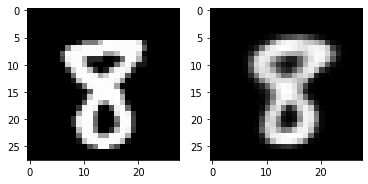

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

idx = 128

(image, label) = test_dataset[idx]
print('GT label:', label)

### 아래에서 ae()가 사용되지 않고, enc()와 dec()가 사용되었음에 주목
X      = torch.unsqueeze(image, 0).to(device) # batch size = 1 
z      = enc(X)   # enc()만 사용해 입력 영상을 인코딩해 latent code z를 구함 
# z      = projection(z)
Y_pred = dec(z)   # dec()만 사용해 latent code z를 디코딩해 출력 영상 Y_pred를 구함

print("latent code z: ", z)

input_img  = to_pil_image(X.squeeze())
output_img = to_pil_image(Y_pred.squeeze())

plt.subplot(121)
plt.imshow(input_img, cmap='gray')

plt.subplot(122)
plt.imshow(output_img, cmap='gray')

인코딩 결과와 유사한 좌표값을 디코딩에 보내도 유사한 결과가 나옴을 확인

In [ ]:
import ipywidgets as widgets

u=widgets.FloatSlider(min=-10.0, max=10.0)
v=widgets.FloatSlider(min=-10.0, max=10.0)

ui = widgets.HBox([u,v])

def z_test(u, v):
  # z_test = np.array([[u,v]])  
  z_test = np.zeros((1, n_dim))
  z_test[0, 0] = u
  z_test[0, 1] = v
  
  print(z_test)
  
  z_test = torch.FloatTensor(z_test).to(device)
  img_gen = dec(z_test)

  img_gen = to_pil_image(img_gen.squeeze())

  plt.imshow(img_gen, cmap='gray')
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v})

display(ui, out)

Output()

## TODO
1. encoder를 거쳐 나온 representation z를 GT label 별로 다른색을 주어 z의 분포를 가시화한다.
2. z의 분포를 보고 encoder가 label 별로 discriminative한 representation을 만들어내는지 여부를 확인한다.
3. 만일 discriminative하지 않다면, autoencoder가 discriminative한 representation z를 학습하도록 z의 차원을 바꿔가면서 실험을 진행한다.
4. 결과에 대한 분석을 작성한다.

## 인코딩 결과 가시화
오토인코더의 encoder가 만들어 내는 representation인 z 값을 가시화 한다. 

torch.Size([980, 8])
torch.Size([1135, 8])
torch.Size([1032, 8])
torch.Size([1010, 8])
torch.Size([982, 8])
torch.Size([892, 8])
torch.Size([958, 8])
torch.Size([1028, 8])
torch.Size([974, 8])
torch.Size([1009, 8])


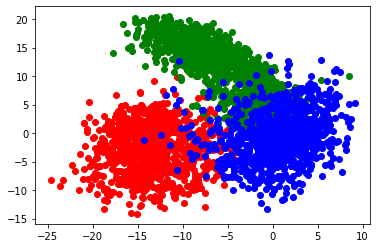

In [ ]:
# MNIST 데이터의 latent code 가시화
import matplotlib.pyplot as plt

# 테스트셋의 whole batch에 대한 결과 확인을 위한 dataloader 정의
whole_test_loader = DataLoader(dataset=test_dataset,
                               batch_size=len(test_dataset),
                               shuffle=False)

whole_test_images, whole_test_labels = next(iter(whole_test_loader))

whole_test_images = whole_test_images.to(device)
whole_test_labels = whole_test_labels.to(device)
## TODO: whole_train_images에 대한 인코딩 함수 enc()를 이용해 latent codes z 구하기 
z = enc(whole_test_images)

# z 배열을 레이블 조건을 이용해 슬라이싱
z_0 = z[whole_test_labels==0]
z_1 = z[whole_test_labels==1]
z_2 = z[whole_test_labels==2]
z_3 = z[whole_test_labels==3]
z_4 = z[whole_test_labels==4]
z_5 = z[whole_test_labels==5]
z_6 = z[whole_test_labels==6]
z_7 = z[whole_test_labels==7]
z_8 = z[whole_test_labels==8]
z_9 = z[whole_test_labels==9]

print(z_0.shape)
print(z_1.shape)
print(z_2.shape)
print(z_3.shape)
print(z_4.shape)
print(z_5.shape)
print(z_6.shape)
print(z_7.shape)
print(z_8.shape)
print(z_9.shape)

# TODO: 레이블 별로 다른 색을 이용해 가시화
plt.plot(z_0[:,0].detach().cpu().numpy(), z_0[:,1].detach().cpu().numpy(), 'ro')
plt.plot(z_1[:,0].detach().cpu().numpy(), z_1[:,1].detach().cpu().numpy(), 'go')
plt.plot(z_2[:,0].detach().cpu().numpy(), z_2[:,1].detach().cpu().numpy(), 'bo')
# plt.plot(z_3[:,0].detach().cpu().numpy(), z_3[:,1].detach().cpu().numpy(), 'co')
# plt.plot(z_4[:,0].detach().cpu().numpy(), z_4[:,1].detach().cpu().numpy(), 'mo')
# plt.plot(z_5[:,0].detach().cpu().numpy(), z_5[:,1].detach().cpu().numpy(), 'yo')
# plt.plot(z_6[:,0].detach().cpu().numpy(), z_6[:,1].detach().cpu().numpy(), 'ko')
# plt.plot(z_7[:,0].detach().cpu().numpy(), z_7[:,1].detach().cpu().numpy(), 'wo')
# plt.plot(z_8[:,0].detach().cpu().numpy(), z_8[:,1].detach().cpu().numpy(), 'xkcd:teal')
# plt.plot(z_9[:,0].detach().cpu().numpy(), z_9[:,1].detach().cpu().numpy(), 'xkcd:purple')

# layer convelution
# z dimension 늘려서 분할시킴

## TODO: 디코더를 이용한 Generative Model 구성
1. z 공간의 임의의 위치를 sampling한 후, 이를 decoder의 입력으로 주는 방식으로 generative model을 구축한다.
2. 결과로 만들어지는 이미지는 어떤 특징을 가지고 있는지 분석한다.

In [ ]:
## TODO
z = torch.randn(1, n_dim)

z = torch.FloatTensor(z).to(device)
result = dec(z)

print(z.shape)
print(result.shape)

torch.Size([1, 8])
torch.Size([1, 1, 28, 28])


결과 가시화

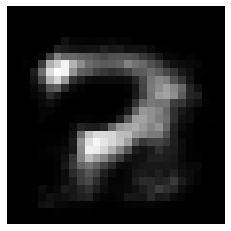

In [ ]:
## TODO

# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# 디코더로부터 생성된 이미지 출력
img = to_pil_image(result.squeeze().detach().cpu())
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## TODO
1. 기존의 `Linear layer`를 `Conv layer`로 변경하여 결과를 확인해본다.
2. `Conv layer`로 변경 후 학습을 진행하고 평가를 진행한다.
3. 결과에 대한 분석을 작성한다.

In [ ]:
images, labels = next(iter(train_loader))
images.shape

torch.Size([100, 1, 28, 28])

In [ ]:
""" 
Convolutional AutoEncoder model 구축 
"""

## TODO
conv_enc = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=2, stride=1, padding=2),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=2, stride=1),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=2, stride=1),
    nn.ReLU(),
    # nn.MaxPool2d(2, 2)
)

conv_dec = nn.Sequential(
    nn.ConvTranspose2d(128, 64, kernel_size=2, stride=1),
    nn.ReLU(),
    nn.ConvTranspose2d(64, 32, kernel_size=2, stride=1),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 1, kernel_size=2, stride=1, padding=2),
    nn.Sigmoid()

)



conv_ae = nn.Sequential(
    conv_enc,
    conv_dec,
)

conv_ae = conv_ae.to(device)

print(conv_ae)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
    (5): ReLU()
  )
  (1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
    (5): Sigmoid()
  )
)


In [ ]:
"""
fit 함수 작성 및 실행
"""

## TODO
def fit(train_loader, num_epochs):
    for epoch in range(num_epochs):
        now = time.time()
        avg_loss = 0
        total_batch = len(train_loader)

        for i, (images, labels) in enumerate(train_loader):
            X = batch_images.to(device)

            Y_prediction = conv_ae(X)
            loss = criterion(Y_prediction, X)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_loss += loss / total_batch

            
            if (i+1) % 100 == 0:
                print("[Epoch: {:>4}] \t loss = {:.4f} \t time = {:.4f}".format(epoch + 1, avg_loss.data, time.time()-now))
    
    print("Learning Finished!")



fit(train_loader, num_epochs)

[Epoch:    1] 	 loss = 0.0266 	 time = 2.2147
[Epoch:    1] 	 loss = 0.0532 	 time = 5.0521
[Epoch:    1] 	 loss = 0.0798 	 time = 8.6555
[Epoch:    1] 	 loss = 0.1065 	 time = 13.3360
[Epoch:    1] 	 loss = 0.1331 	 time = 16.7396
[Epoch:    1] 	 loss = 0.1597 	 time = 18.8240
[Epoch:    2] 	 loss = 0.0266 	 time = 2.0140
[Epoch:    2] 	 loss = 0.0532 	 time = 4.2016
[Epoch:    2] 	 loss = 0.0798 	 time = 6.2775
[Epoch:    2] 	 loss = 0.1065 	 time = 8.2839
[Epoch:    2] 	 loss = 0.1331 	 time = 10.2748
[Epoch:    2] 	 loss = 0.1597 	 time = 12.2567
[Epoch:    3] 	 loss = 0.0266 	 time = 1.9713
[Epoch:    3] 	 loss = 0.0532 	 time = 4.2055
[Epoch:    3] 	 loss = 0.0798 	 time = 6.1791
[Epoch:    3] 	 loss = 0.1065 	 time = 8.1339
[Epoch:    3] 	 loss = 0.1331 	 time = 10.0779
[Epoch:    3] 	 loss = 0.1597 	 time = 12.0255
[Epoch:    4] 	 loss = 0.0266 	 time = 1.9295
[Epoch:    4] 	 loss = 0.0532 	 time = 4.2510
[Epoch:    4] 	 loss = 0.0798 	 time = 6.1845
[Epoch:    4] 	 loss = 0.10

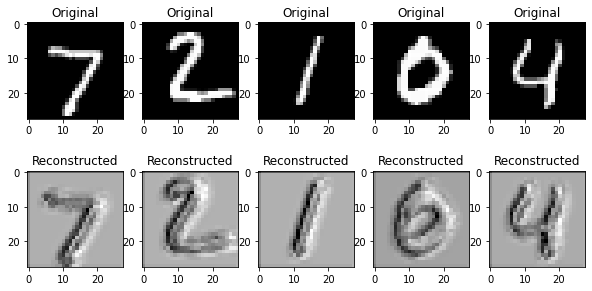

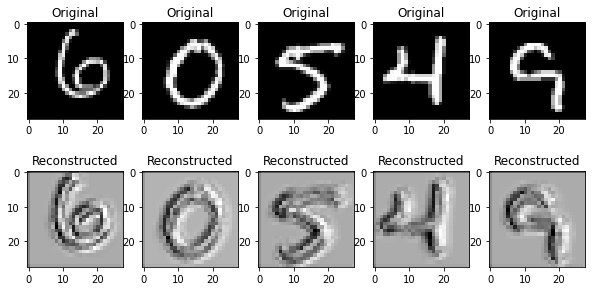

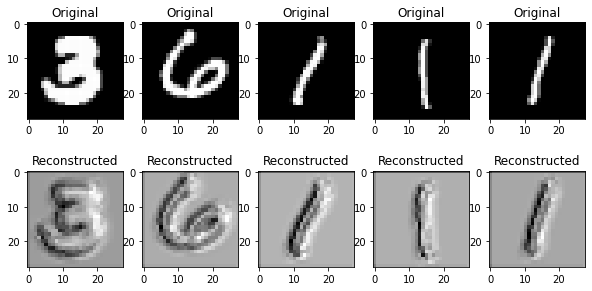

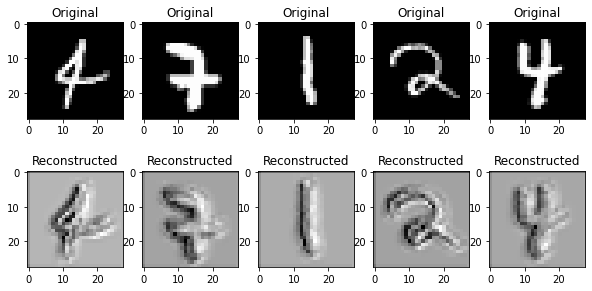

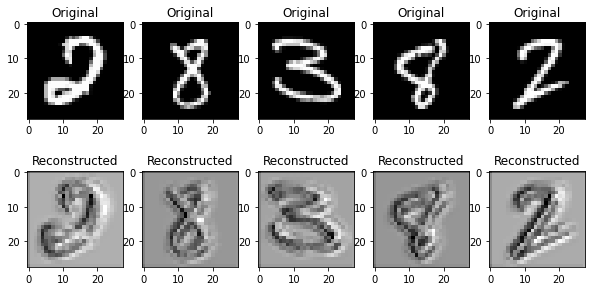

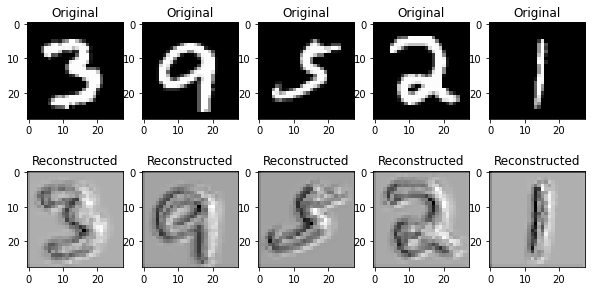

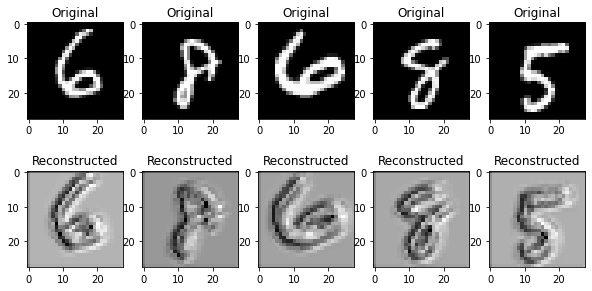

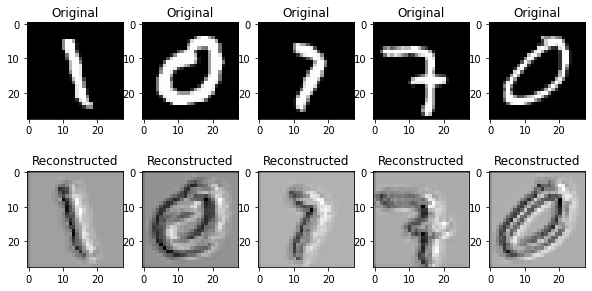

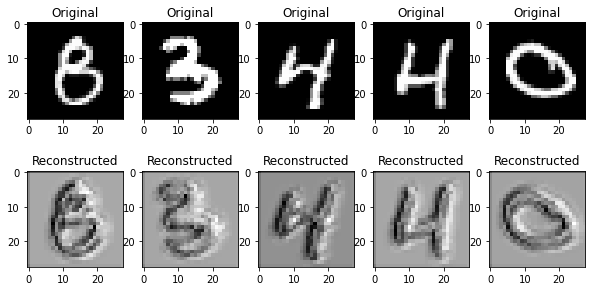

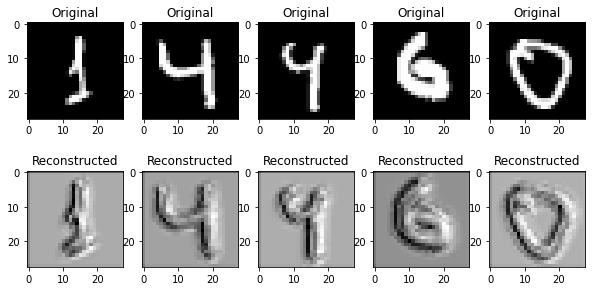

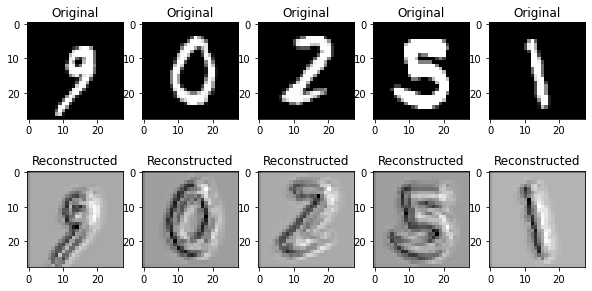

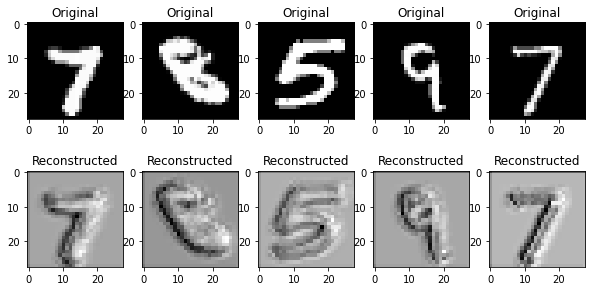

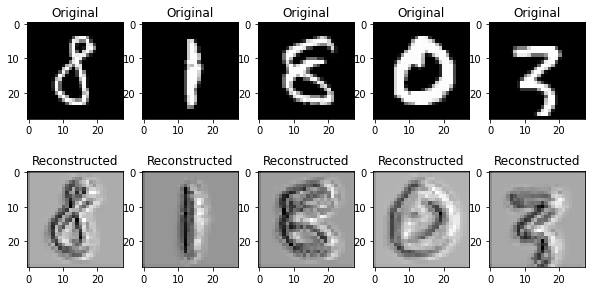

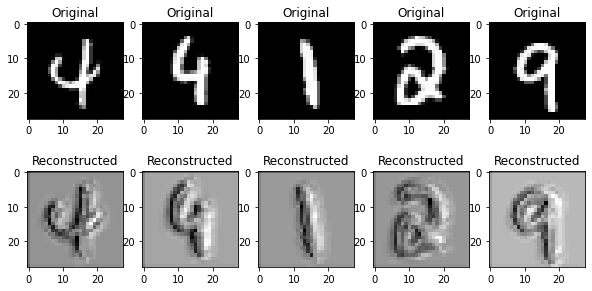

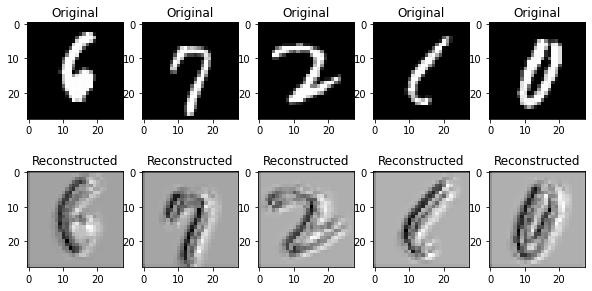

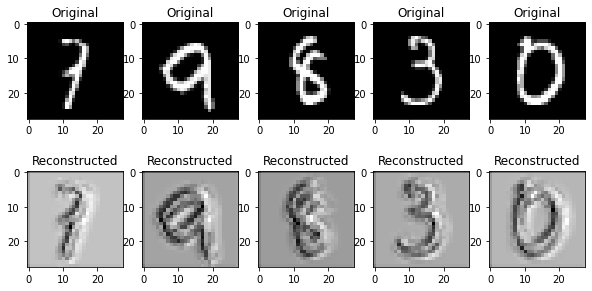

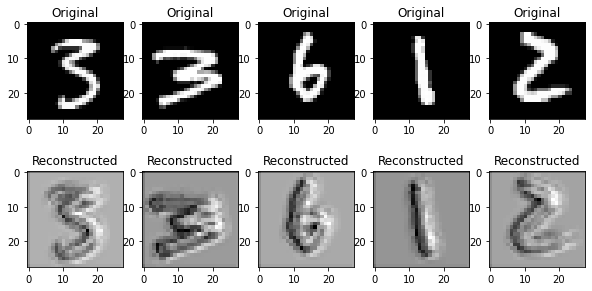

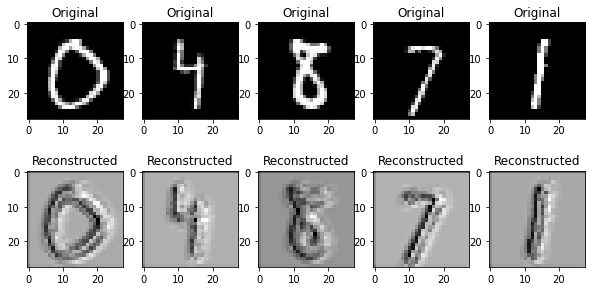

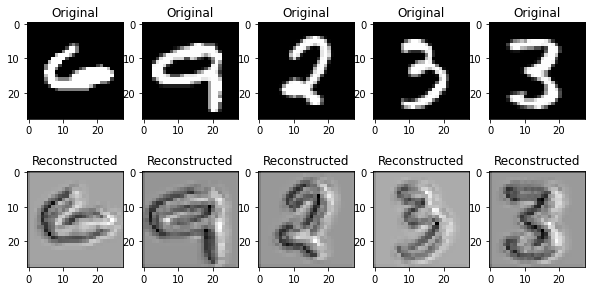

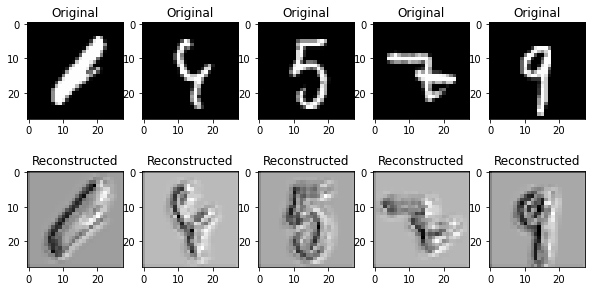

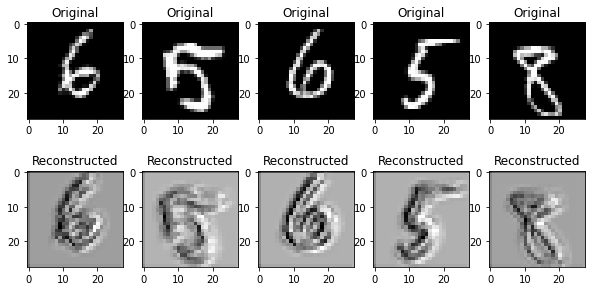

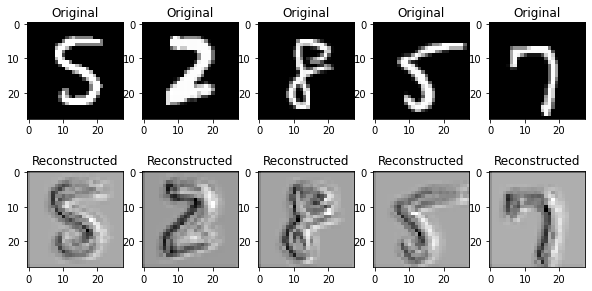

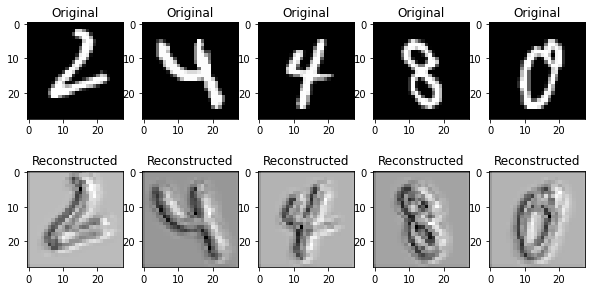

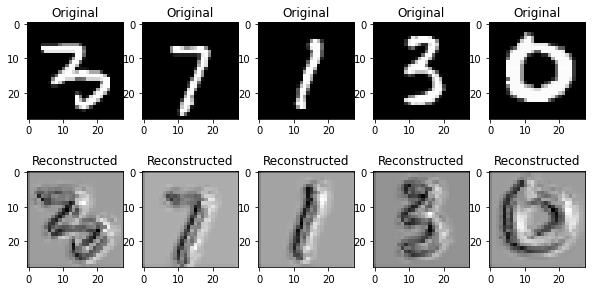

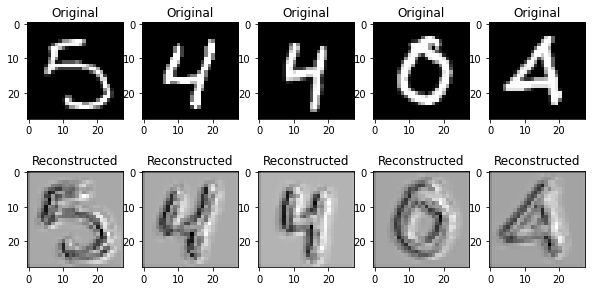

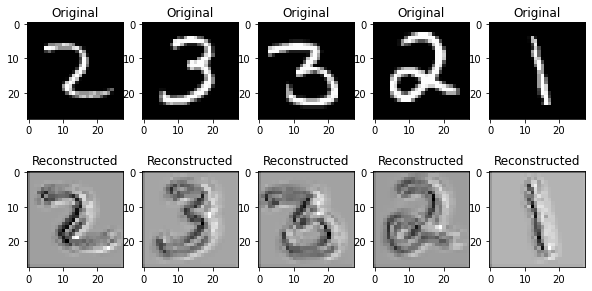

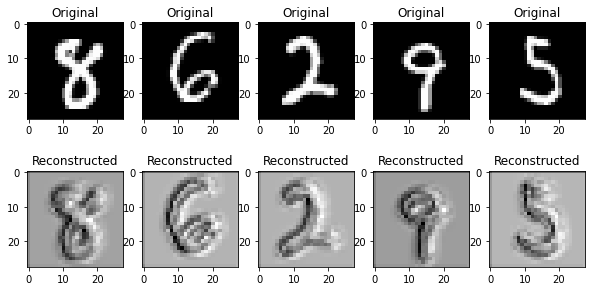

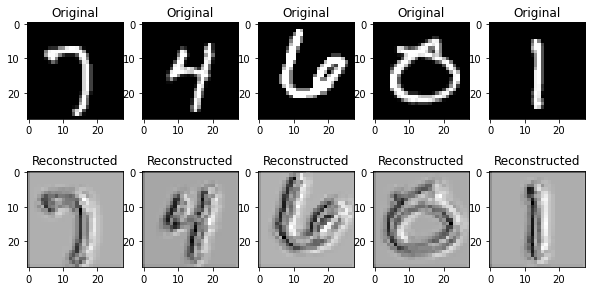

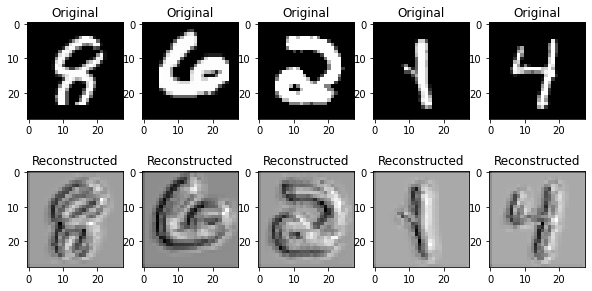

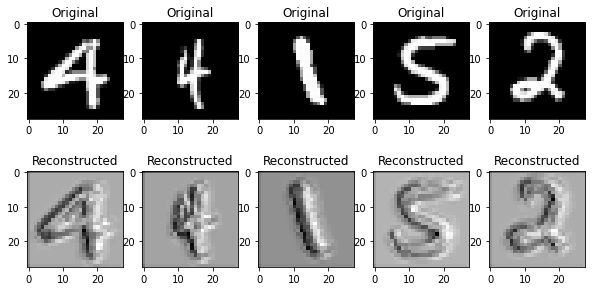

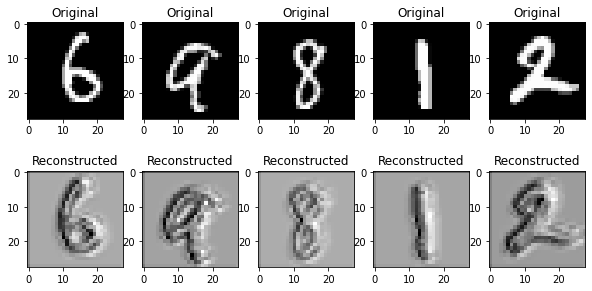

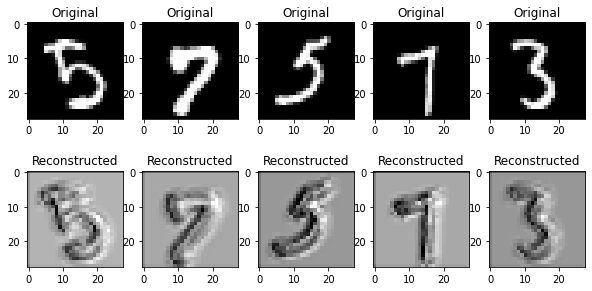

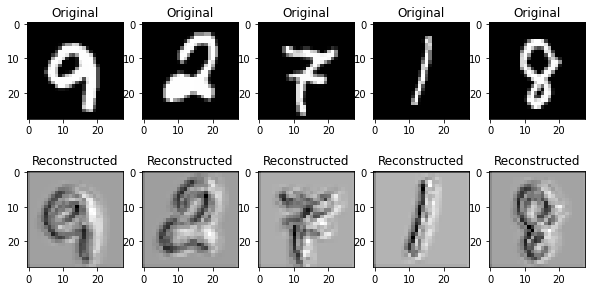

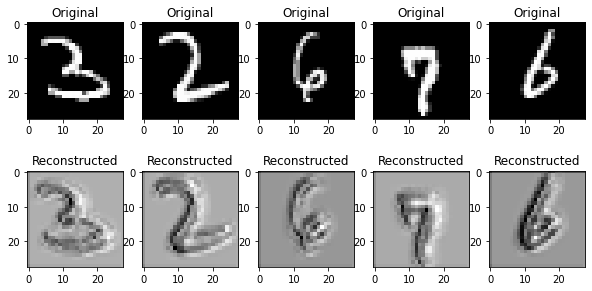

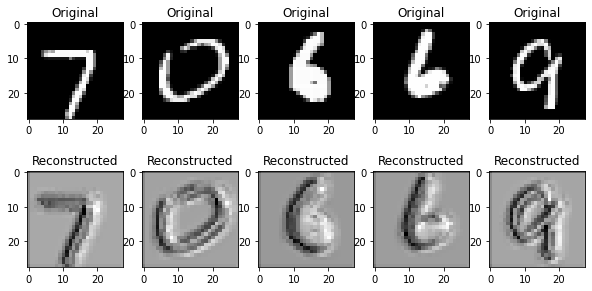

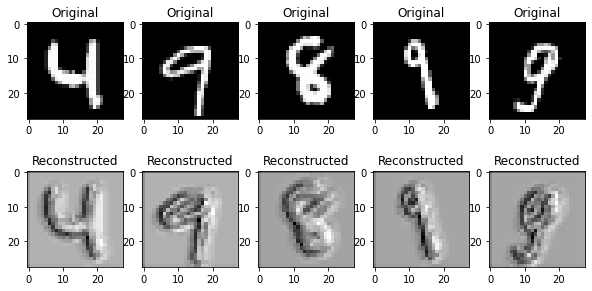

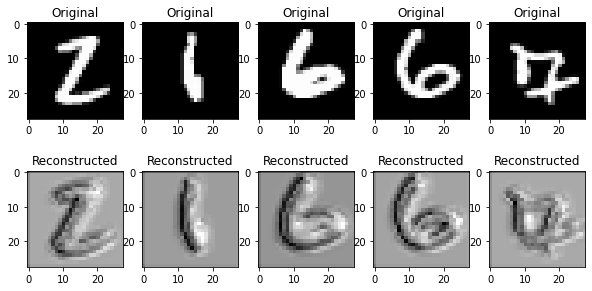

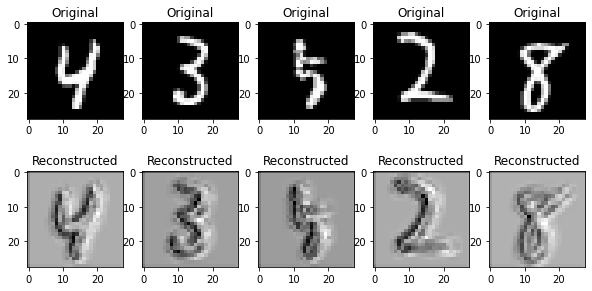

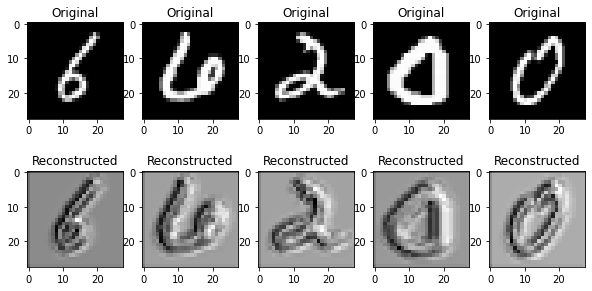

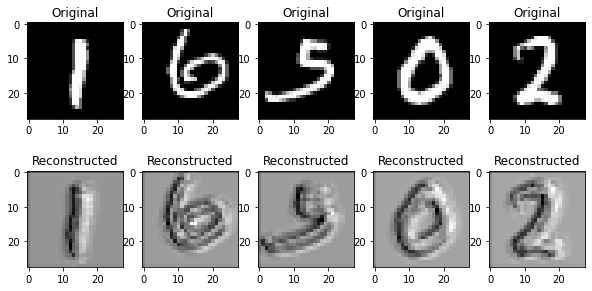

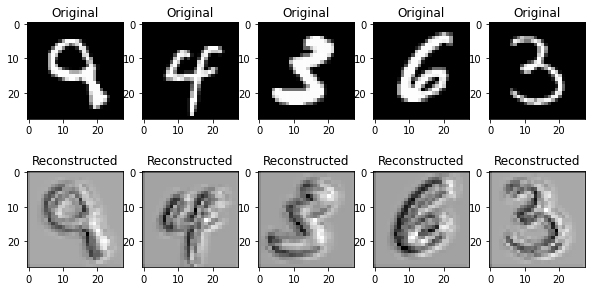

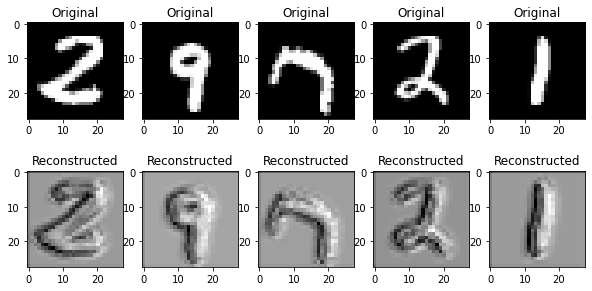

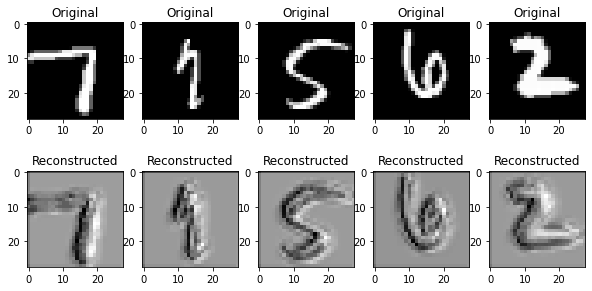

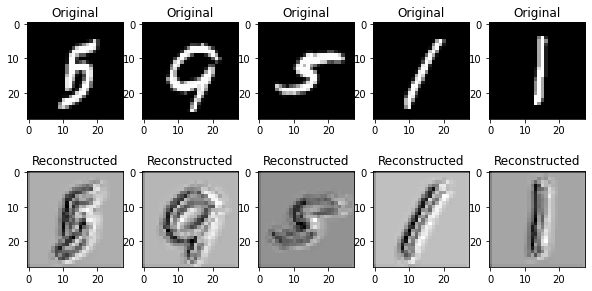

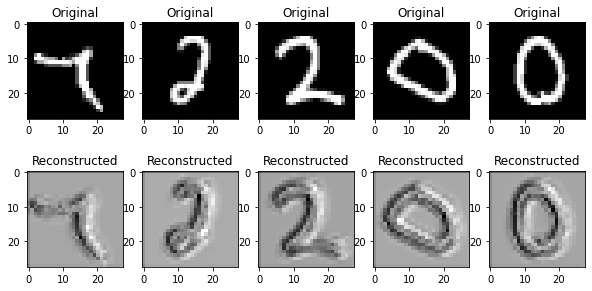

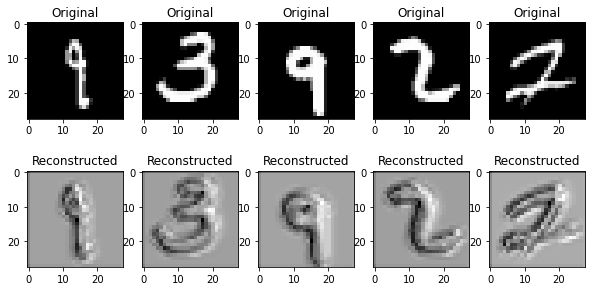

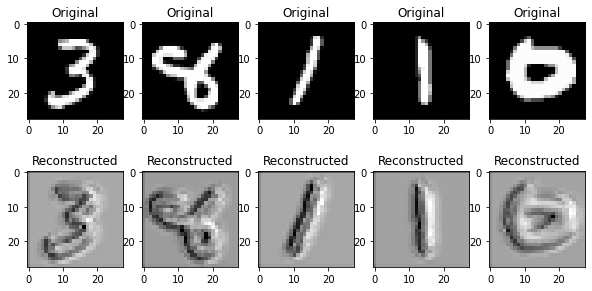

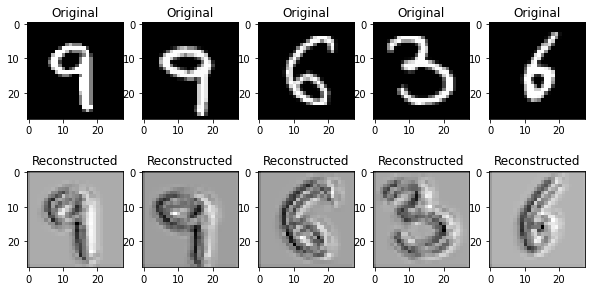

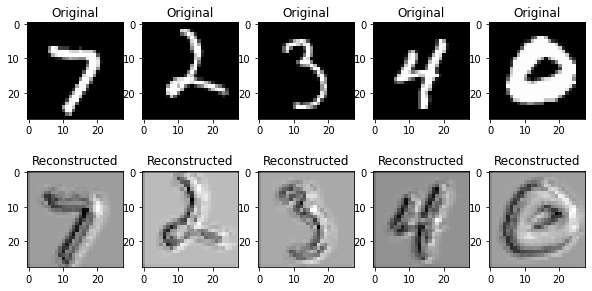

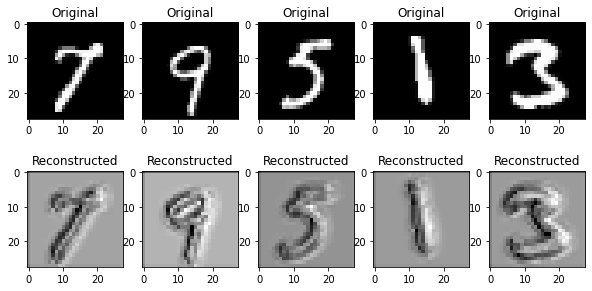

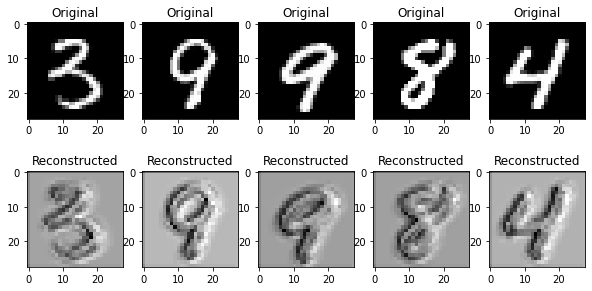

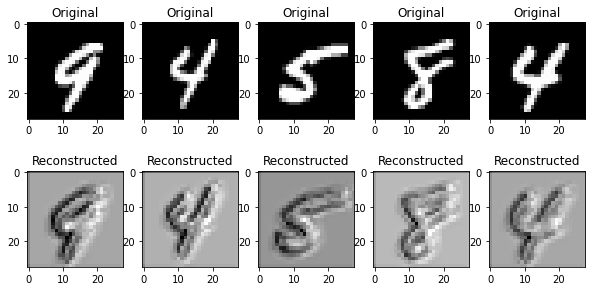

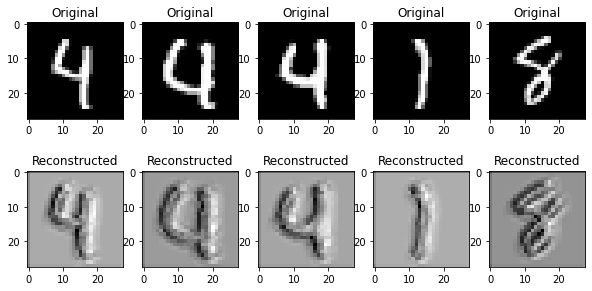

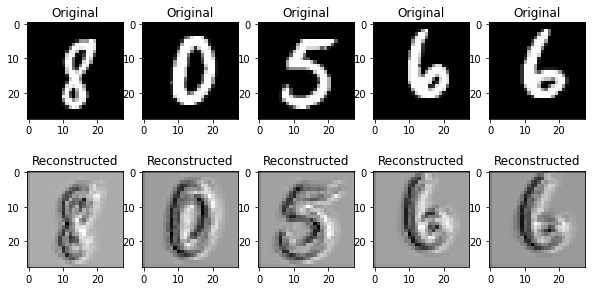

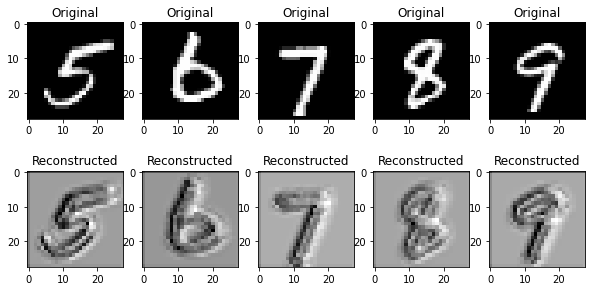

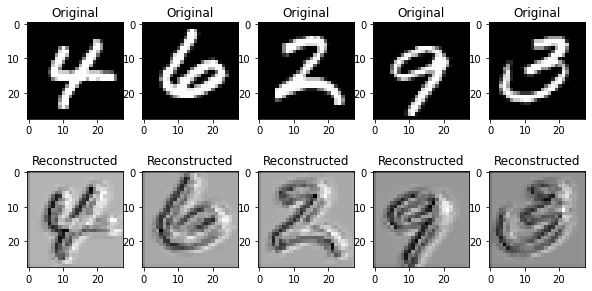

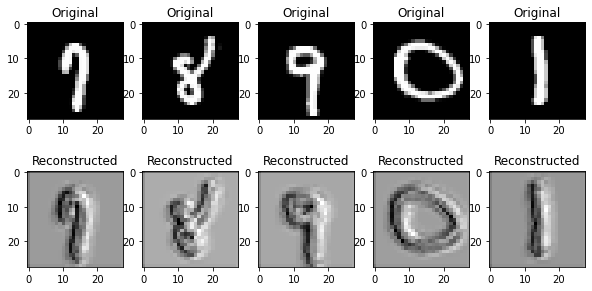

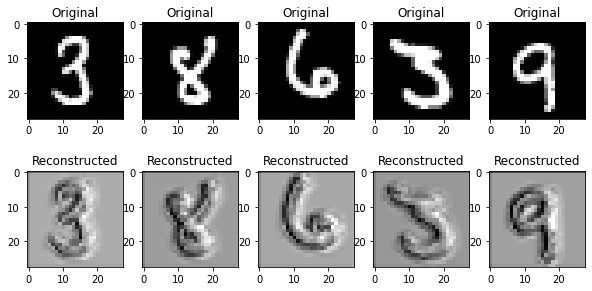

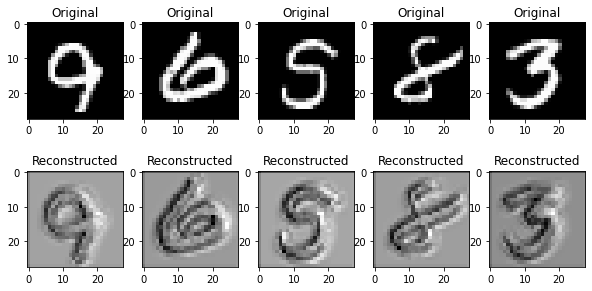

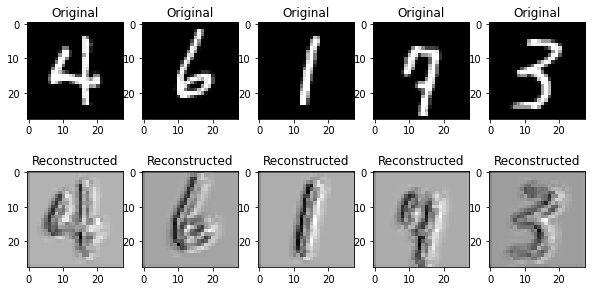

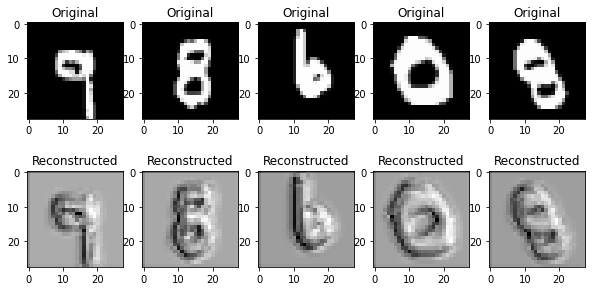

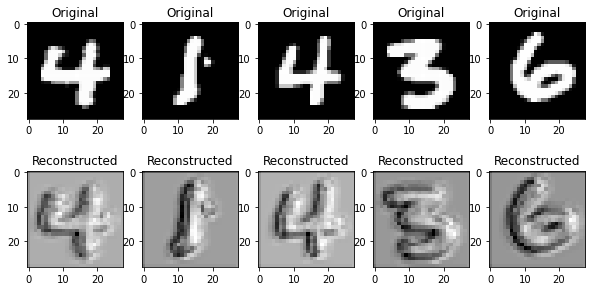

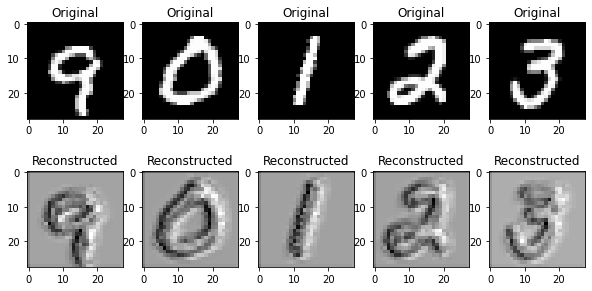

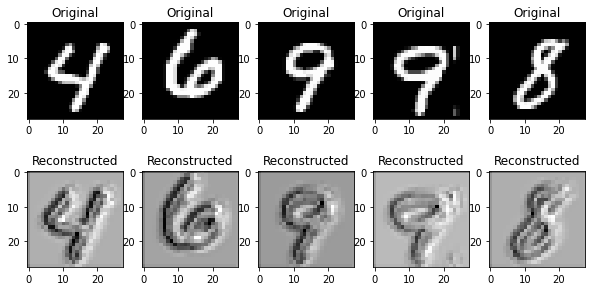

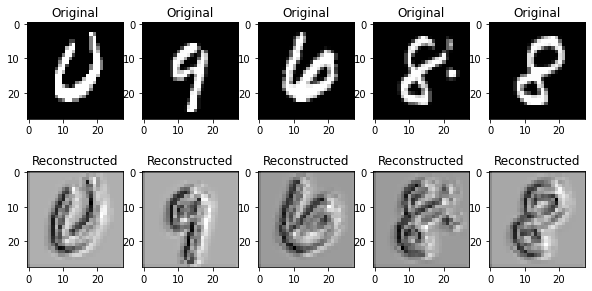

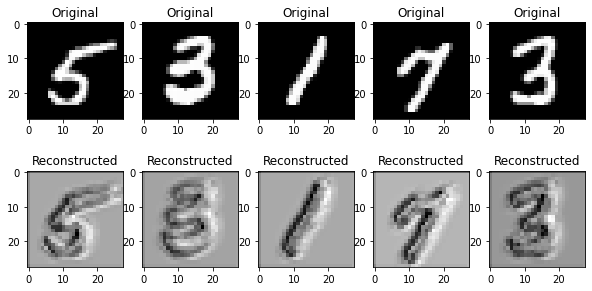

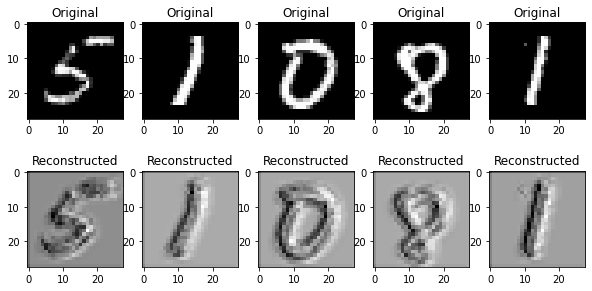

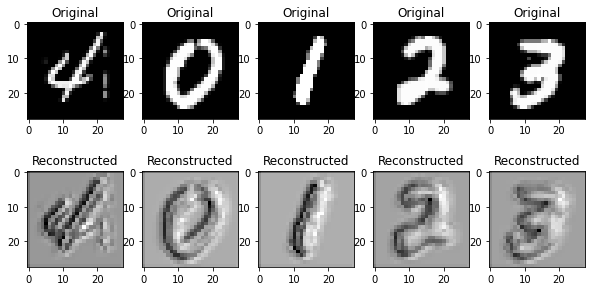

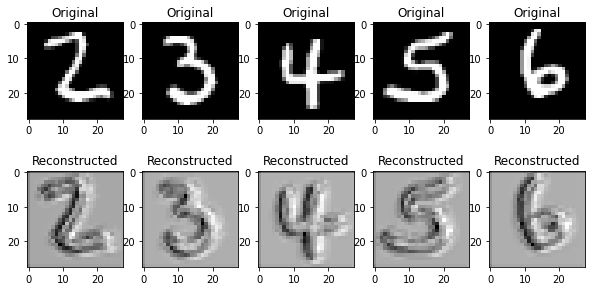

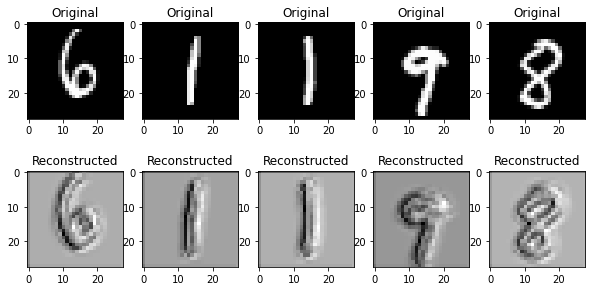

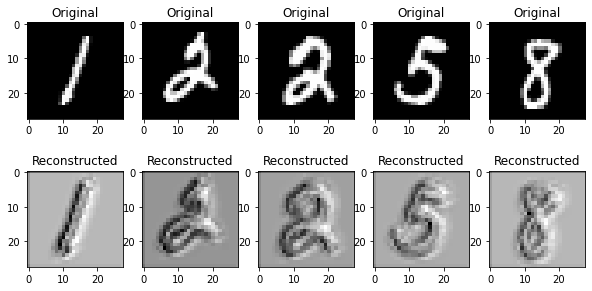

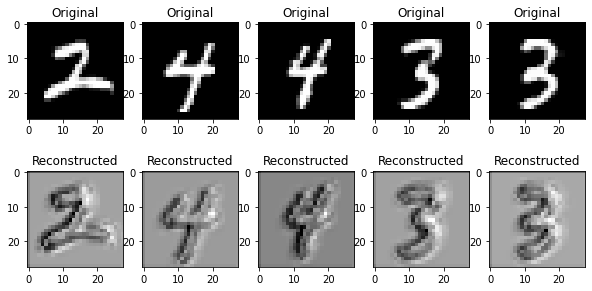

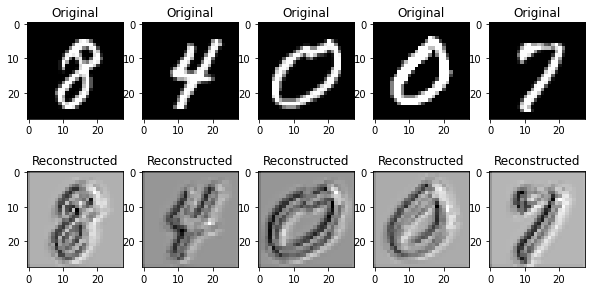

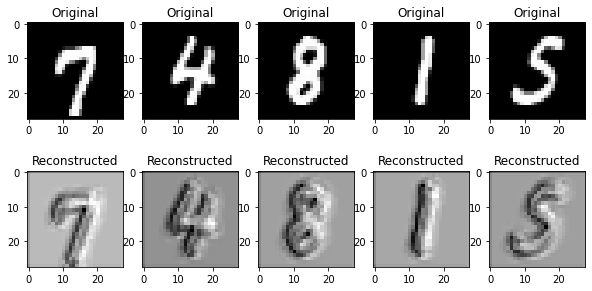

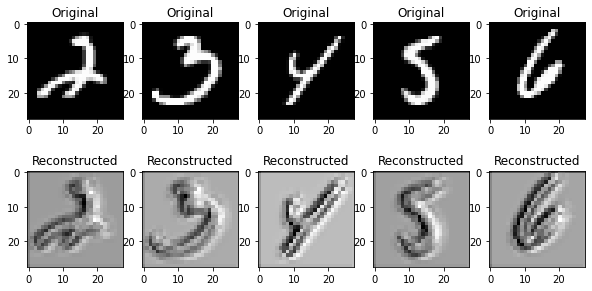

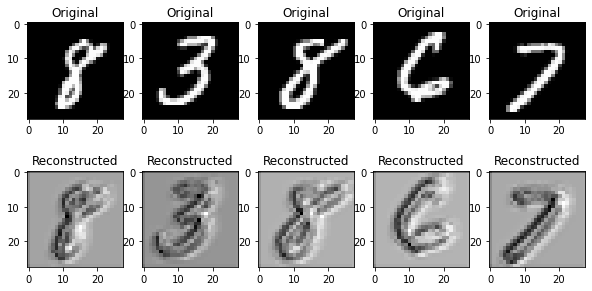

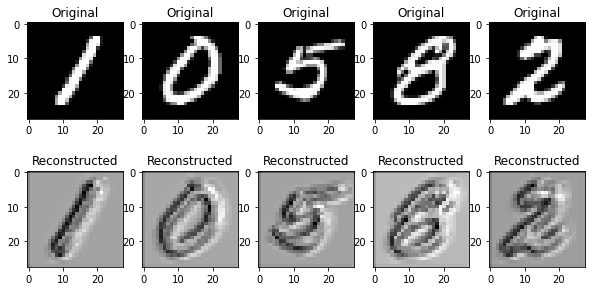

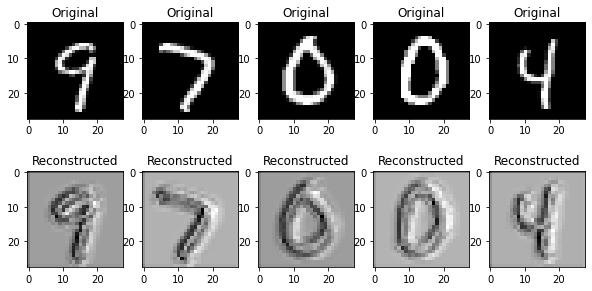

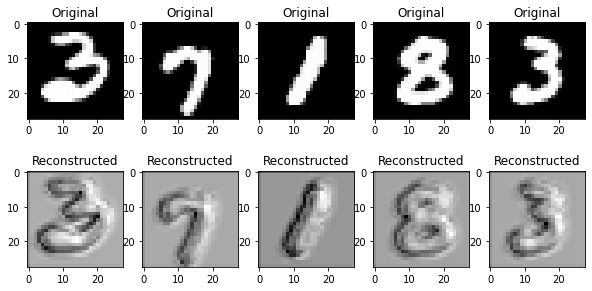

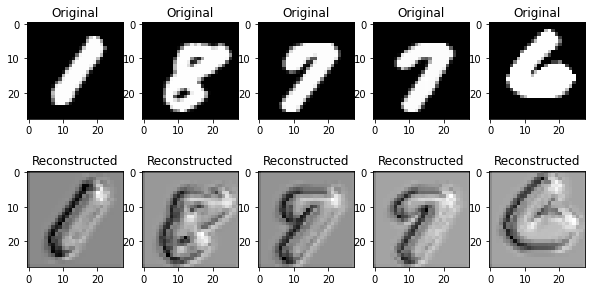

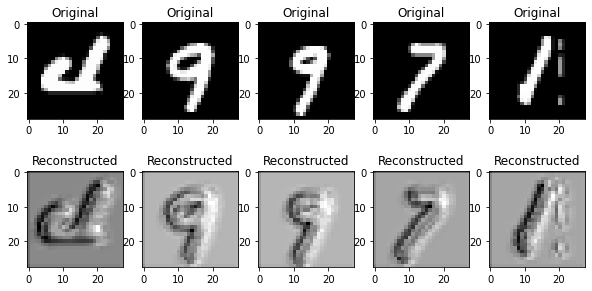

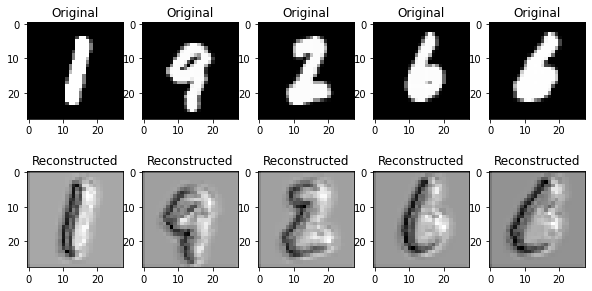

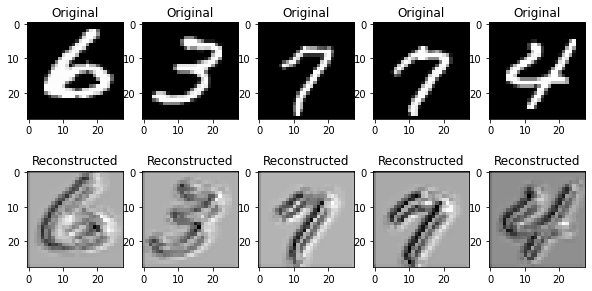

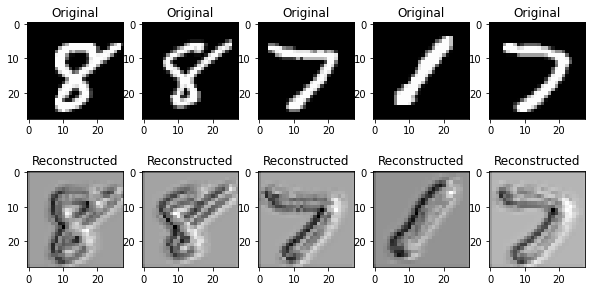

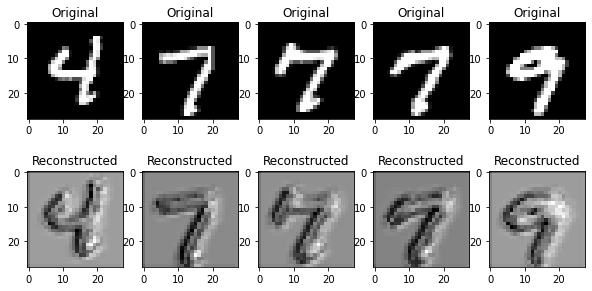

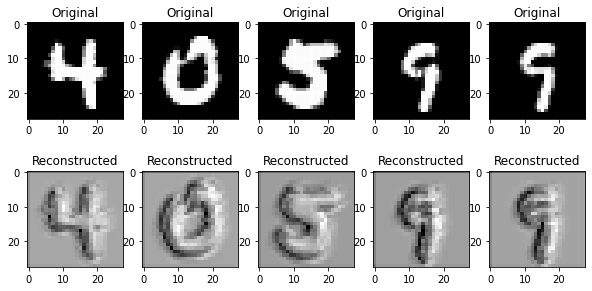

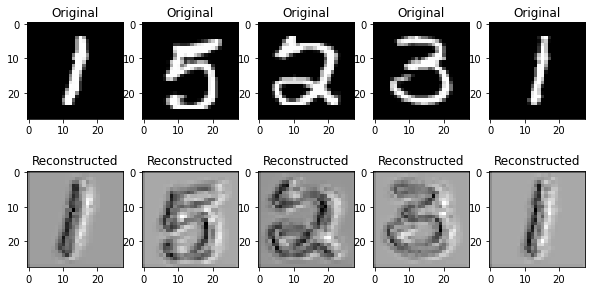

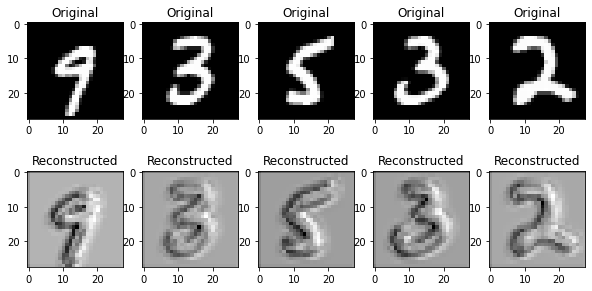

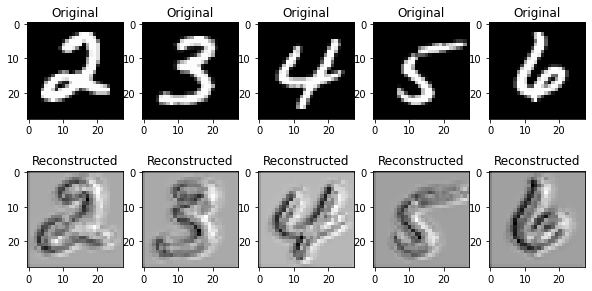

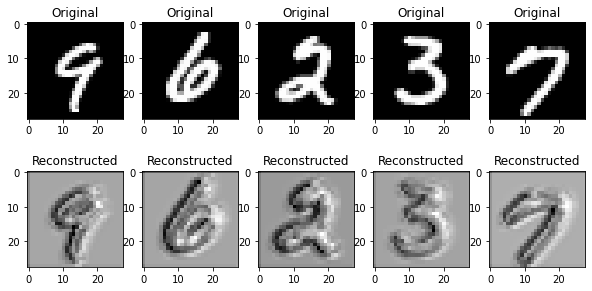

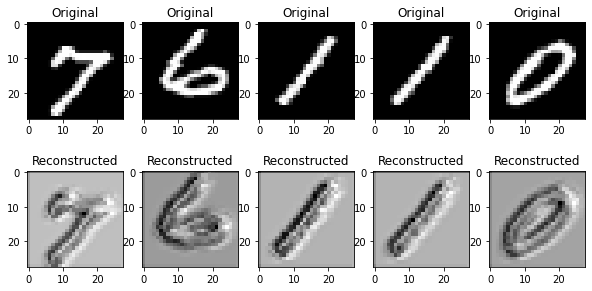

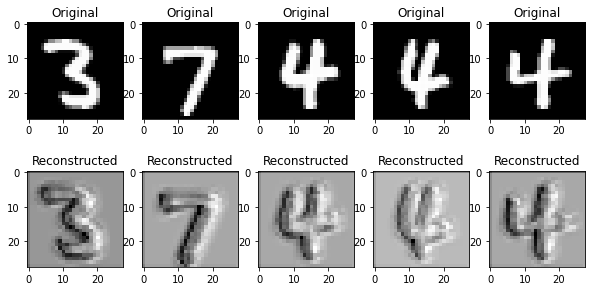

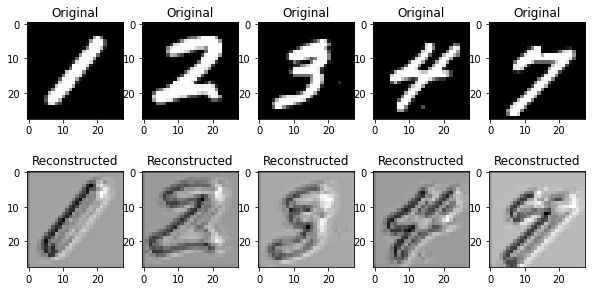

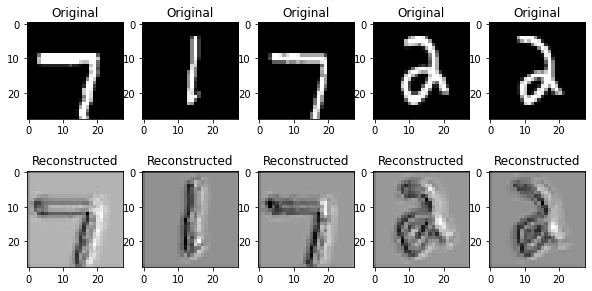

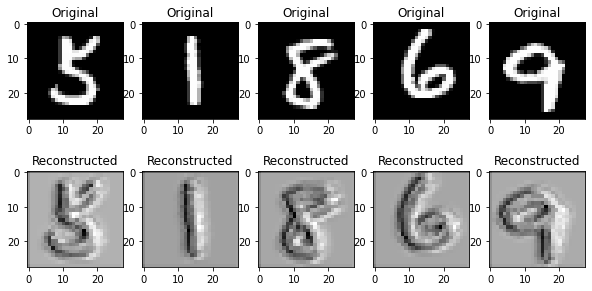

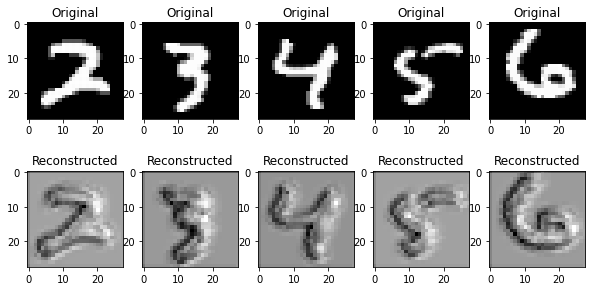

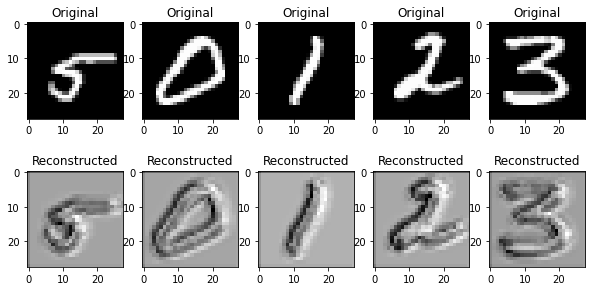

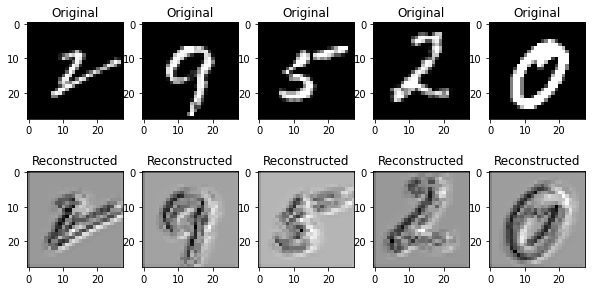

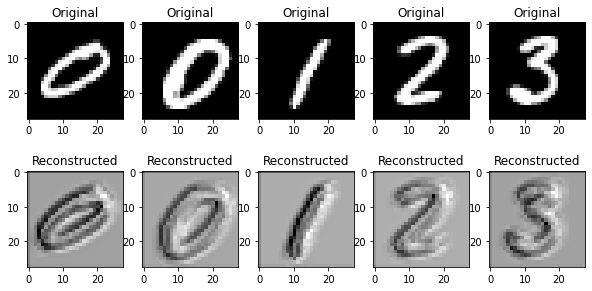

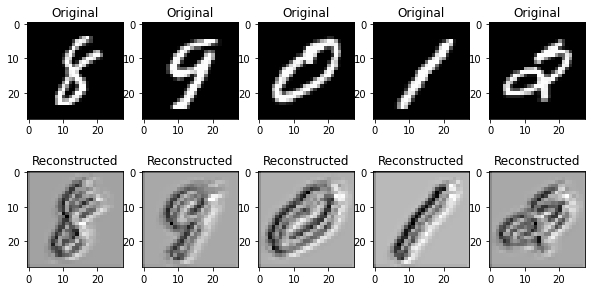

In [ ]:
"""
학습된 Convolutional Autoencoder 통과
"""

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        recon_images = conv_ae(images) # 입력 데이터에 대한 재구성 결과
        # 이미지 출력
        plt.figure(figsize=(10, 5))
        for i in range(5):
            plt.subplot(2, 5, i+1)
            plt.imshow(images[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.title("Original")
            plt.subplot(2, 5, i+6)
            plt.imshow(recon_images[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.title("Reconstructed")
            
        plt.show()



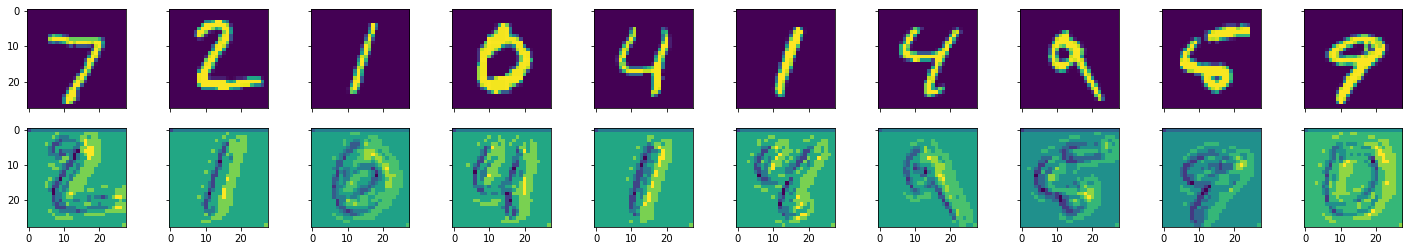

In [ ]:
"""
Convolutional Autoencoder 결과 확인
"""
## TODO
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# 입력 이미지 추출
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print(images[1:])

# 재구성 이미지 생성
with torch.no_grad():
    encoded = conv_enc(images[1:].to(device))
    decoded = conv_dec(encoded)

# 원본 이미지와 재구성 이미지 시각화
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25, 4))

for i in range(10):
    axes[0, i].imshow(to_pil_image(images[i]))
    axes[1, i].imshow(to_pil_image(decoded[i]))

plt.show()

